In [2]:
# Third-party
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from scipy.interpolate import InterpolatedUnivariateSpline

from pyia import GaiaData
from ezpadova import parsec
from brokenimf import new_kroupa_mass_distribution # borrowed from AMUSE

Using an IMF implementation from the AMUSE code:

In [3]:
ms = new_kroupa_mass_distribution(100000)

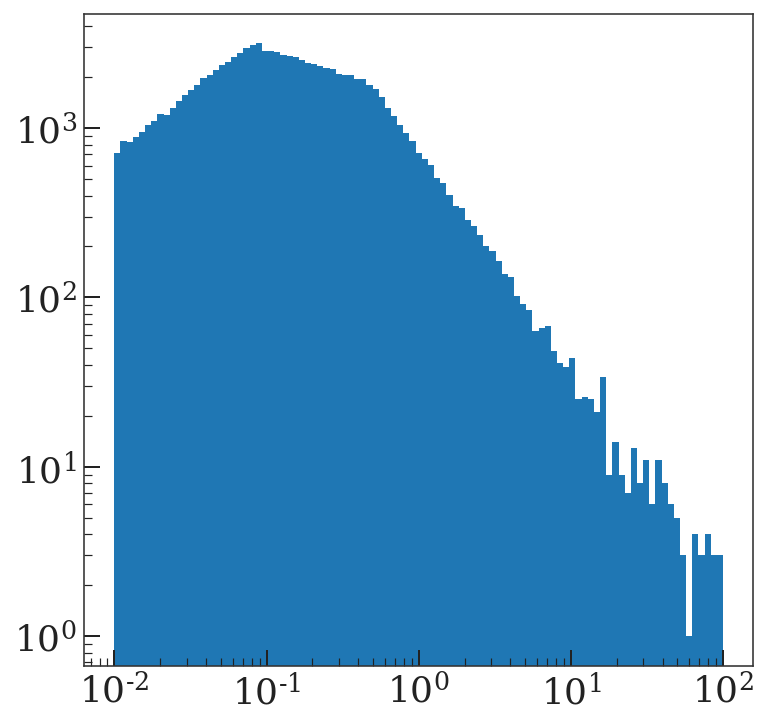

In [4]:
plt.hist(ms.value, bins=np.logspace(-2, 2, 100));
plt.xscale('log')
plt.yscale('log')

In [5]:
_iso_cache = {}

In [6]:
import copy

Zsun = 0.0152

class PARSECIsochrone:
    
    _label_to_name = {0: 'PMS',
                      1: 'MS',
                      2: 'SGB',
                      3: 'RGB',
                      4: 'CHeB1',
                      5: 'CHeB2',
                      6: 'CHeB3',
                      7: 'EAGB',
                      8: 'TPAGB',
                      9: 'WD'}
    
    def __init__(self, filename=None, tbl=None, age=None, phot=None, 
                 fe_h=None, Z=None, **kwargs):
        
        if filename is not None:
            raise NotImplementedError()
            
        elif tbl is not None:
            self.tbl = tbl
            
        else:
            if age is None or phot is None or (fe_h is None and Z is None):
                raise ValueError('If no filename is specified, you must pass '
                                 'in age, photometry name, and metallicity '
                                 'information. See `parsec.get_one_isochrone()`')
        
            if fe_h is not None and Z is not None:
                raise ValueError('You can only specify one of Z or [Fe/H] (fe_h) '
                                 'to specify the metallicity')
                
            if hasattr(age, 'unit'):
                age = age.to(u.yr).value
            
            if isinstance(phot, str):
                phot = [phot]
                
            if fe_h is not None:
                Z = Zsun * 10**fe_h
            
            iso_tbls = []
            for ph in phot:
                cache_key = (age, Z, ph)
                if cache_key in _iso_cache: # isochrone in cache
                    iso = _iso_cache[cache_key]
                
                else: # download isochrone, not in cache
                    iso = parsec.get_one_isochrone(age, Z, phot=ph)
                    iso = iso.to_astropy_table()
                    _iso_cache[cache_key] = iso
                    
                iso_tbls.append(iso)
                
            self.tbl = self._merge_isos(iso_tbls)
        
    def _merge_isos(self, isos):
        if len(isos) == 0:
            return
        
        master_iso = isos[0]

        for iso in isos[1:]:
            if len(iso) != len(master_iso):
                raise ValueError('Lengths must match to merge isochrones.')

            for c in iso.colnames:
                if c in master_iso.colnames:
                    continue

                master_iso[c] = iso[c]

        return master_iso
    
    ##########################################################################
    # Python internal
    #
    
    def __getattr__(self, name):
        # to prevent recursion errors:
        # nedbatchelder.com/blog/201010/surprising_getattr_recursion.html
        if name in ['tbl']:
            raise AttributeError()
            
        elif name not in self.tbl.colnames:
            return self.__getattribute__(name)
            
        return self.tbl[name]

    def __dir__(self):
        return super().__dir__() + self.tbl.colnames
    
    def __getitem__(self, slc):
        if isinstance(slc, int):
            slc = slice(slc, slc+1)
        return type(self)(tbl=self.tbl[slc])

    def __len__(self):
        return len(self.tbl)
    
    
    ##########################################################################
    # Custom
    #
    
    @property
    def stage_names(self):
        if not hasattr(self, '_stage_names'):
            self._stage_names = np.array([self._label_to_name[l] for l in self.label])
        return self._stage_names

In [10]:
iso = PARSECIsochrone(age=13 * u.Gyr,
                      fe_h=-1.5,
                      phot=['gaiaDR2', 'panstarrs1'])

Interrogating http://stev.oapd.inaf.it...
http://stev.oapd.inaf.it/cgi-bin/cmdn_inTPC=10&cmd_version=2.9&dust_sourceC=nodustC&dust_sourceM=nodustM&eta_reimers=0.2&extinction_av=0&imf_file=tab_imf%2Fimf_chabrier_lognormal.dat&isoc_age=13000000000.0&isoc_age0=12700000000.0&isoc_dlage=0.05&isoc_dz=0.0001&isoc_kind=parsec_CAF09_v1.2S_NOV13&isoc_lage0=6.6&isoc_lage1=10.13&isoc_val=0&isoc_z0=0.0001&isoc_z1=0.03&isoc_zeta=0.00048066620434559365&isoc_zeta0=0.008&kind_cspecmag=aringer09&kind_dust=0&kind_interp=1&kind_mag=2&kind_postagb=-1&kind_pulsecycle=0&kind_tpagb=0&lf_deltamag=0.2&lf_maginf=20&lf_magsup=-20&output_evstage=0&output_gzip=0&output_kind=0&photsys_file=tab_mag_odfnew%2Ftab_mag_gaiaDR2.dat&photsys_version=yang&submit_form=Submit


RuntimeError: Server Response is incorrect

In [71]:
ms_iso = iso[iso.stage_names == 'MS']

In [72]:
interp_G = InterpolatedUnivariateSpline(iso.Mini, iso.Gmag, ext=3)
interp_BPRP = InterpolatedUnivariateSpline(iso.Mini, iso.G_BPmag-iso.G_RPmag, ext=3)

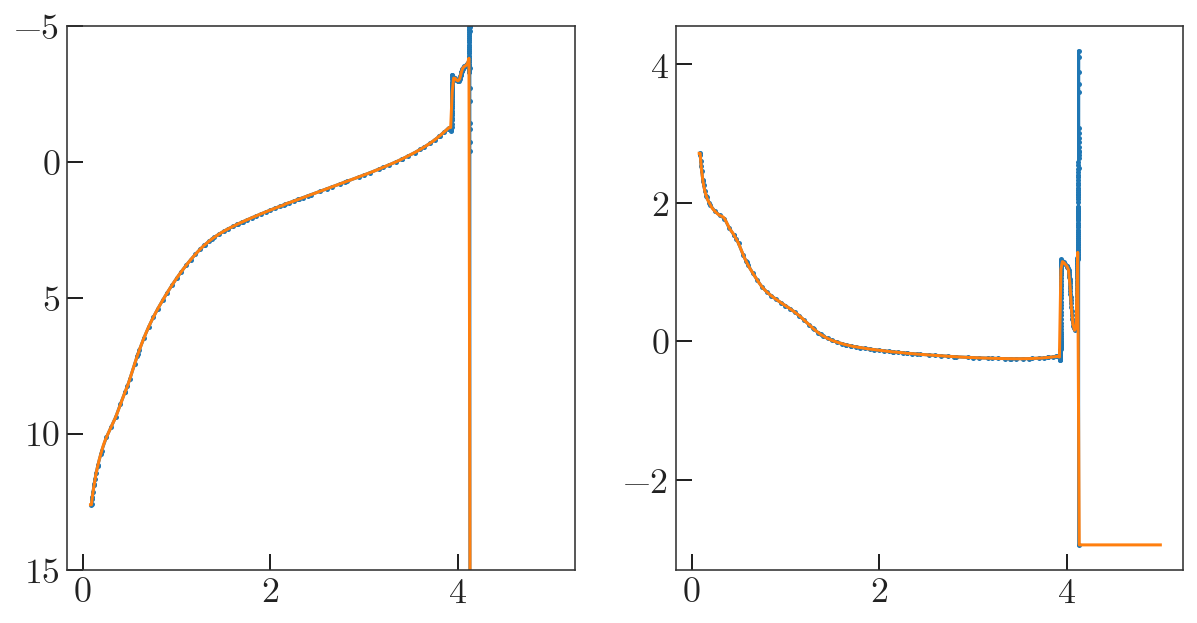

In [73]:
mini_grid = np.logspace(np.log10(0.08), np.log10(5), 1024)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

axes[0].plot(iso.Mini, iso.Gmag)
axes[0].set_ylim(15, -5)
axes[0].plot(mini_grid, interp_G(mini_grid), marker='')

axes[1].plot(iso.Mini, iso.G_BPmag-iso.G_RPmag)
axes[1].plot(mini_grid, interp_BPRP(mini_grid), marker='')

In [78]:
Gs = interp_G(ms.value)
BPRPs = interp_BPRP(ms.value)
DM = coord.Distance(30*u.kpc).distmod.value

(-1, 2)

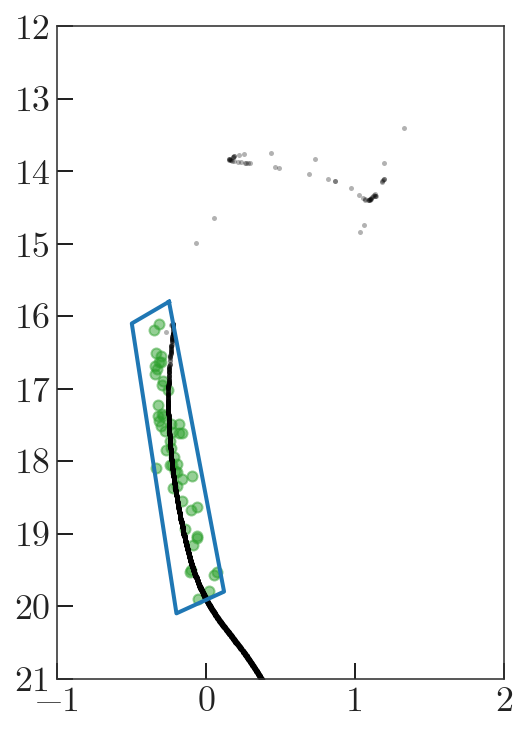

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))
ax.plot(BPRPs, Gs + DM, 
        marker='.', ls='none', alpha=0.3, color='k')

ax.scatter(g.BP0 - g.RP0, g.G0, zorder=-100, 
           alpha=0.5, color='tab:green')

nodes = np.array([[-0.25, 15.8],
                  [0.12, 19.8],
                  [-0.2, 20.1],
                  [-0.5, 16.1],
                  [-0.25, 15.8]])
ax.plot(nodes[:, 0], nodes[:, 1], marker='', color='tab:blue', lw=2)
cmd_path = mpl.patches.Path(nodes)

ax.set_ylim(21, 12)
ax.set_xlim(-1, 2)

In [80]:
sim_mask = cmd_path.contains_points(np.vstack((BPRPs, Gs + DM)).T)
frac = len(g) / sim_mask.sum()

In [81]:
frac * ms.sum()

<Quantity 761.04684683 solMass>

---

In [44]:
from imf.brokenimf import new_kroupa_mass_distribution
from scipy.interpolate import interp1d

In [45]:
med_pp = np.median(np.vstack(sampler.chain[:, :]), axis=0)
med_pp

array([  0.94648274,   8.15784063,  29.76033846,  -1.0896264 ])

In [46]:
_iso = Table.read('/Users/adrian/data/Isochrones/MIST/FeH_-1.2_iso.fits')
_iso = _iso[np.isclose(_iso['log10_isochrone_age_yr'], round(med_pp[1], 1))]
_iso = _iso[(_iso['EEP'] > 202) & (_iso['EEP'] < 455)]

In [47]:
_gi = _iso['dec_g'] - _iso['dec_i']
_g = _iso['dec_g'] + coord.Distance(med_pp[2]*u.kpc).distmod.value

In [48]:
np.median(samples['AV'])

0.1448096475462394

(22, 15)

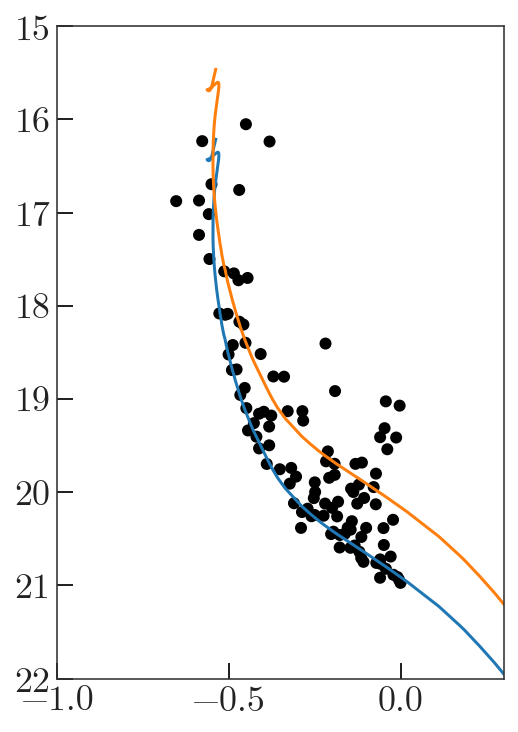

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))
ax.scatter(col, mag, c=post_prob,
           marker='o', cmap='Greys', 
           vmin=0, vmax=1)

ax.plot(_gi + 0.17, _g + 0.14, 
        marker='')

ax.plot(_gi + 0.17, _g + 0.14 - 0.75, 
        marker='')

ax.set_xlim(-1, 0.3)
ax.set_ylim(22, 15)

In [50]:
m_to_g = interp1d(_iso['star_mass'], _g, bounds_error=False)

In [54]:
masses = new_kroupa_mass_distribution(3000).value
_gs = m_to_g(masses)
_gs = _gs[np.isfinite(_gs)]

(array([  1.,   3.,   4.,   6.,   7.,  15.,  14.,  24.,  18.,  21.]),
 array([ 16.05107117,  16.54324131,  17.03541145,  17.5275816 ,
         18.01975174,  18.51192188,  19.00409203,  19.49626217,
         19.98843231,  20.48060246,  20.9727726 ]),
 <a list of 10 Patch objects>)

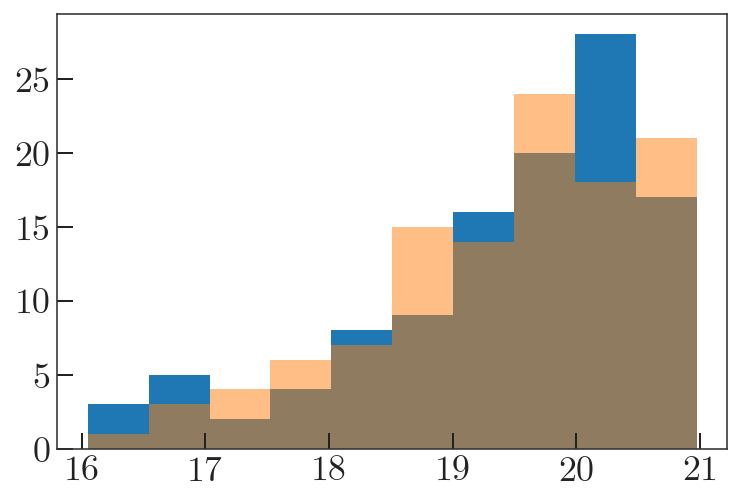

In [55]:
_, bins, _ = plt.hist(mag, weights=post_prob);
plt.hist(_gs, alpha=0.5, bins=bins)

In [56]:
masses.sum()

1187.8914812495514

## Cluster physical properties

In [12]:
age = 130*u.Myr

In [1]:
((110 * u.arcmin) * (135 * u.pc)).to(u.pc, u.dimensionless_angles())

<Quantity 4.319689898685966 pc>

In [3]:
size = ((1.5*u.deg) * (29*u.kpc)).to(u.pc, u.dimensionless_angles())
print(size)

759.2182246175333 pc


In [4]:
(size / (130*u.Myr)).to(u.km/u.s)

<Quantity 5.710443650642355 km / s>

In [5]:
((0.5*u.mas/u.yr) * (29*u.kpc)).to(u.km/u.s, u.dimensionless_angles())

<Quantity 68.73682172069502 km / s>